# Plotting of data

In [1]:
import re
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import function_definitions as field_funcs
import OCP_construction_functions as OCP_funcs
def get_floats_from_filename(filename):
    return re.findall(r"[+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", filename)


def create_dict_for_folder(folderdir):
    file_names_in_folder = os.listdir(folderdir)
    stepsize_filename_dict = dict()
    for x in file_names_in_folder:
        stepsize_filename_dict[x] = [float(y)  for y in get_floats_from_filename(x)] #assume fix order a,b,gamma,h
    return stepsize_filename_dict    
    

In [2]:
base_folder_dir = 'data/pendulum_inversion'
def get_data_from_folder(foldername):
    folder_names = os.listdir(foldername+'/')
    dict_of_folders_with_files = dict()
    for x in folder_names:
        if x != '.DS_Store':
            dict_of_folders_with_files[x] = create_dict_for_folder(foldername+'/' +x)
    #Structure of data dict:
        # data_dict["folder_name"]=[ {"file_name":data}, [alpha,beta,gamma,h] ]
    data_dict = dict()
    for x in dict_of_folders_with_files.keys():
        for y in dict_of_folders_with_files[x].keys():
            if y == '.DS_Store':
                continue

            filename = foldername+"/"+x + "/"+y
            with open(filename, 'rb') as files:
                data_dict[y] = [pickle.load(files) ,dict_of_folders_with_files[x][y]]
    return data_dict            

base_folder_dir_test = base_folder_dir
base_foldername = base_folder_dir_test 
data=get_data_from_folder(base_foldername)


In [ ]:
use_data = data['data_a=0.5g=1N=350.pkl'][0]

qd = use_data['q_d_new']
vqd = use_data['v_y_d_new'][:,:2]
vxid = use_data['v_y_d_new'][:,2:]
xid = use_data['lambda_d_new']
lamqd = use_data['lambda_q_standard']
lamvd = use_data['lambda_v_standard']
ud_new = use_data['u_d_new']

continuous_eq = OCP_funcs.Direct_continuous_generator_forced_L(use_data['parameters'],Lagrangian=field_funcs.pendulum_cart_lagrangian,f_L=field_funcs.f_L,running_cost_func=field_funcs.running_cost_pendulum,mayer_func=field_funcs.mayer_term_pendulum,g_func=field_funcs.g_mat_pendulum,I_func=field_funcs.conserved_I_control_pendulum)
discrete_equations = OCP_funcs.discrete_standard_direct_eq_generator_forced_L(continuous_eq)
continuous_eq.calc_v_xi_from_standard_variables();


# Generating the reference via the indirect solution

In [ ]:
ref_name = 'data/pendulum_inversion/reference/reference_indirect.pkl'

with open(ref_name, 'rb') as filetmp:
    ref_data = pickle.load(filetmp)

import scipy
import sympy

t_ref = np.array(ref_data["time"])





cs_q_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["state_x"],ref_data["state_theta"]]).transpose())
cs_lambda_q_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["costate_x"],ref_data["costate_theta"]]).transpose())
cs_lambda_v_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["costate_vx"],ref_data["costate_vtheta"]]).transpose())
cs_u_d_ref =  scipy.interpolate.CubicSpline(t_ref, np.array(ref_data["control"]).reshape((len(t_ref),1)))
cs_v_q_ref = scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["state_vx"],ref_data["state_vtheta"]]).transpose())

xi_ref = np.array([continuous_eq.calc_xi_from_standard_variables(tmpq,tmplamq) for tmpq,tmplamq in zip(cs_q_ref(t_ref),cs_lambda_v_ref(t_ref))])
cs_xi_ref = scipy.interpolate.CubicSpline(t_ref, xi_ref)

vxi_vars = [continuous_eq.q,continuous_eq.vq,continuous_eq.lamq,continuous_eq.lamv,continuous_eq.xi_vars,continuous_eq.u]
vxi_vars = sympy.flatten(vxi_vars)
lambdified_vxi = sympy.lambdify(vxi_vars,continuous_eq.v_xi_as_lamq_vec)
v_xi_ref = np.array([lambdified_vxi(*tmpq,*tmpvq,*tmplamq,*tmplamv,*tmpxi,*tmpu).flatten() for tmpq,tmpvq,tmplamq,tmplamv,tmpxi,tmpu in zip(cs_q_ref(t_ref),cs_v_q_ref(t_ref),cs_lambda_q_ref(t_ref),cs_lambda_v_ref(t_ref),cs_xi_ref(t_ref),cs_u_d_ref(t_ref).reshape((len(t_ref),1)))])


cs_v_xi_ref = scipy.interpolate.CubicSpline(t_ref, v_xi_ref)
cs_v_y_d_ref = lambda x: np.append(cs_v_q_ref(x).transpose() , cs_v_xi_ref(x).transpose() ,0).transpose()
cs_lambda_d_new_ref =  cs_lambda_v_ref
cs_H_d_new_ref =  scipy.interpolate.CubicSpline(t_ref, -np.array(ref_data["Hamiltonian"]))


import sympy
I_func_lambdified = sympy.lambdify(sympy.flatten(discrete_equations.all_vars_new_approach),discrete_equations.cont_equations.I_func)
I_new_ref = []
for tmpq,tmpxi,tmpvy,tmpu in zip(cs_q_ref(t_ref),cs_xi_ref(t_ref),cs_v_y_d_ref(t_ref),cs_u_d_ref(t_ref)):
    I_new_ref.append(np.array(I_func_lambdified(*tmpq,*tmpvy[:2],*tmpxi,*(tmpvy[2:]),*tmpu),float).flatten())
I_new_ref=np.array(I_new_ref).flatten()

cs_I_d_new_ref =  scipy.interpolate.CubicSpline(t_ref, I_new_ref)


ref_curves = {"q_d_new":cs_q_ref, "lambda_q_standard":cs_lambda_q_ref, "lambda_v_standard":cs_lambda_v_ref
              ,"u_d_new": cs_u_d_ref, "v_y_d_new":cs_v_y_d_ref,"lambda_d_new":cs_xi_ref
              , "I_d_new":cs_I_d_new_ref, "H_control_new":cs_H_d_new_ref}

def calculate_error(vec, ref_vec):
    error_vec = vec-ref_vec
    if not isinstance(vec,np.ndarray):
        error = error_vec*(error_vec)
    else:
        error = error_vec.dot(error_vec)
    return np.sqrt(error)
    
def calculate_max_error_curve(vec_curve, ref_curve):
    errors = []
    for vec,ref_vec in zip(vec_curve,ref_curve):
        errors.append(calculate_error(vec,ref_vec))
    return max(errors)


In [5]:
def calc_v_xi_I_for_postprocessing_data(data):
    q_d = data['q_d_standard']
    vq_d = data['vq_d_standard']
    lambda_q_d = data['lambda_q_standard']
    lambda_v_d = data['lambda_v_standard']
    xi_d = data['xi_calc_standard']
    u_d = data['u_d_standard']

    v_xi_d = np.array([lambdified_vxi(*tmpq,*tmpvq,*tmplamq,*tmplamv,*tmpxi,*tmpu).flatten() for tmpq,tmpvq,tmplamq,tmplamv,tmpxi,tmpu in zip(q_d,vq_d,lambda_q_d,lambda_v_d,xi_d,u_d)],float)
    I_d = []
    for tmpq,tmpxi,tmpvq,tmpvxi,tmpu in zip(q_d,xi_d,vq_d,v_xi_d,u_d):
        I_d.append(np.array(I_func_lambdified(*tmpq,*tmpvq,*tmpxi,*tmpvxi,*tmpu),float).flatten())
    I_d=np.array(I_d).flatten()
    data['I_standard_evo'] = I_d
    data['v_xi_calc_standard'] = v_xi_d
    # return v_xi_d, I_d


In [6]:
# doing some (optional) post-processing calculation of I and v_xi for all data
for tmp_key in data.keys():
    if not 'reference' in tmp_key:
        calc_v_xi_I_for_postprocessing_data(data[tmp_key][0])

In [7]:
alpha_choice,gamma_choice = 0.5,0.5

N_choices = [50,100,150,200,250,300,350,400,450,500,600]
N_choices = [50,100,150,200,250,300,350]

h_choices = [1.0/tmp for tmp in N_choices]

def get_convergence_data_from_N_vals(data_choice,N_vals,data_dict,alpha,gamma):
    ts = []
    list_chosen_data = []
    for tmp in N_vals:
        file_name_u =  "data_a="+str(alpha)+"g="+str(gamma)+"N="+str(tmp)+".pkl"   
        loaded_dict = data_dict[file_name_u][0]
        ts.append(loaded_dict["parameters"]["times"])
        list_chosen_data.append(loaded_dict[data_choice])
    return ts,list_chosen_data

def get_error_for_approach_keys(approach_key, N_vals, data_dict, alpha,gamma,reference_curve,for_vy_get_q_part=True,skip_end_vals=None):
    times,data_vals = get_convergence_data_from_N_vals(approach_key,N_vals,data_dict,alpha,gamma)
    if "v_y" not in approach_key:
        errors =[calculate_max_error_curve(tmpcurve[:skip_end_vals],reference_curve(tmpt)[:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]
    else:
        if for_vy_get_q_part:
            errors =[calculate_max_error_curve(tmpcurve[:,:2][:skip_end_vals],reference_curve(tmpt)[:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]
        else:
            errors =[calculate_max_error_curve(tmpcurve[:,2:][:skip_end_vals],reference_curve(tmpt)[:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]

    return errors,times



def get_error_data_alpha_gamma(alpha_choice,gamma_choice):
    new_approach_keys= ['q_d_new','lambda_d_new', 'u_d_new', 'v_y_d_new', 'I_d_new', 'H_control_new']
    all_errors_dict = dict()
    # new approach error calculation
    for i in [0,1,2,4,5]:
        all_errors_dict[new_approach_keys[i]],_ = get_error_for_approach_keys(new_approach_keys[i],N_choices,data,alpha_choice,gamma_choice,ref_curves[new_approach_keys[i]],skip_end_vals=-2)
    i_choice = 3
    vq_ref_eval = lambda x : ref_curves[new_approach_keys[i_choice]](x)[:,:2]
    all_errors_dict["v_q_new"],_ = get_error_for_approach_keys(new_approach_keys[i_choice],N_choices,data,alpha_choice,gamma_choice,vq_ref_eval,True,skip_end_vals=-2)
    vlam_ref_eval = lambda x : ref_curves[new_approach_keys[i_choice]](x)[:,2:]
    all_errors_dict["v_lambda_new"],times = get_error_for_approach_keys(new_approach_keys[i_choice],N_choices,data,alpha_choice,gamma_choice,vlam_ref_eval,False,skip_end_vals=-2)

    ###########################
    ###########################
    # standard approach error calc - though not clear what ref solution should be until we use the proper reference solution
    ###########################
    ###########################
    standard_approach_keys= [ 'q_d_standard', 'lambda_v_standard', 'lambda_q_standard','vq_d_standard', 'u_d_standard', 'I_standard_evo', 'H_pontry_standard']
    standard_ref_keys = ['q_d_new', 'lambda_v_standard','lambda_q_standard','v_y_d_new', 'u_d_new','I_d_new','H_control_new']
    all_errors_dict_standard=dict()
    for i in [0,1,2,4,5]:
        all_errors_dict_standard[standard_approach_keys[i]],_ = get_error_for_approach_keys(standard_approach_keys[i],N_choices,data,alpha_choice,gamma_choice,ref_curves[standard_ref_keys[i]],skip_end_vals=-2)

    all_errors_dict_standard[standard_approach_keys[3]],_ = get_error_for_approach_keys(standard_approach_keys[3],N_choices,data,alpha_choice,gamma_choice,vq_ref_eval,skip_end_vals=-2)

    ref_H_curve = lambda x: -ref_curves["H_control_new"](x)
    all_errors_dict_standard[standard_approach_keys[-1]],_ = get_error_for_approach_keys(standard_approach_keys[-1],N_choices,data,alpha_choice,gamma_choice,ref_H_curve,skip_end_vals=-2)
    return all_errors_dict,all_errors_dict_standard,times


data_dicts_a1g0 = get_error_data_alpha_gamma(1,0)
data_dicts_a1g1 = get_error_data_alpha_gamma(0.5,1)
data_dicts_a05g05 = get_error_data_alpha_gamma(0.5,0.5)



In [8]:
def model_curve(x,a,b):
    return a*x**b
def fit_to_data(x_vals, data):
    fit_result = scipy.optimize.curve_fit(model_curve,x_vals,data)
    return fit_result

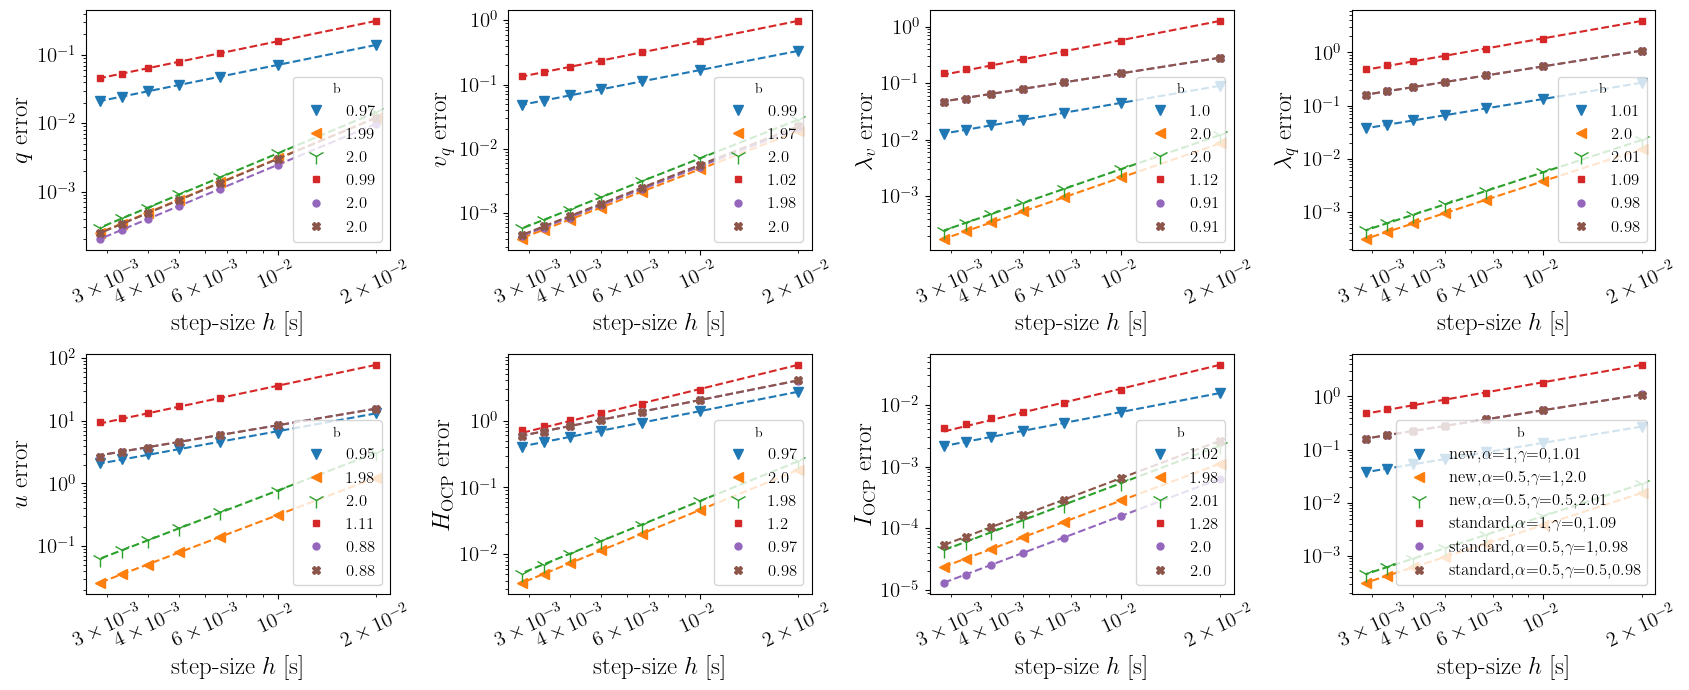

In [ ]:
labelfont = 18
tickfont = 15
legendfont = 12

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "amsmath"
})

def create_error_plot(x_vals,error_data,labeltxt,axs_obj,markerstyle='x',markersize=8,colorstyle='blue'):
    fit_params = fit_to_data(x_vals,error_data)
    axs_obj.plot(x_vals,error_data,markerstyle,label=labeltxt + str(np.round(fit_params[0][1],2)),markersize=markersize,color=colorstyle)
    axs_obj.plot(x_vals,model_curve(x_vals,*fit_params[0]),'--',color=colorstyle)

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','C4','C5']
symbols = ['v','<','1','s','o','X']
symbolsizes = [7,7,12,5,5,6]
fig=plt.figure(figsize=(17, 7))
ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,2)
ax3 = plt.subplot(2,4,3)
ax4 = plt.subplot(2,4,4)
ax5 = plt.subplot(2,4,5)
ax6 = plt.subplot(2,4,6)
ax7 = plt.subplot(2,4,7)
ax8 = plt.subplot(2,4,8)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]


chosen_ax = axs[0]
create_error_plot(h_choices,data_dicts_a1g0[0]["q_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["q_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["q_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["q_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["q_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["q_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$q$ error',fontsize=labelfont)


chosen_ax =axs[1]
create_error_plot(h_choices,data_dicts_a1g0[0]["v_q_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["v_q_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["v_q_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["vq_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["vq_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["vq_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$v_q$ error',fontsize=labelfont)

chosen_ax =axs[2]
create_error_plot(h_choices,data_dicts_a1g0[0]["lambda_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["lambda_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["lambda_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_v_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_v_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_v_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$\lambda_v$ error',fontsize=labelfont)

chosen_ax =axs[3]
create_error_plot(h_choices,data_dicts_a1g0[0]["v_lambda_new"],r"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["v_lambda_new"],r"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["v_lambda_new"],r"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_q_standard"],r"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_q_standard"],r"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_q_standard"],r"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$\lambda_q$ error',fontsize=labelfont)


chosen_ax = axs[4]
create_error_plot(h_choices,data_dicts_a1g0[0]["u_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["u_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["u_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["u_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["u_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["u_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$u$ error',fontsize=labelfont)

chosen_ax = axs[5]
create_error_plot(h_choices,data_dicts_a1g0[0]["H_control_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["H_control_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["H_control_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["H_pontry_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["H_pontry_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["H_pontry_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$H_\mathrm{OCP}$ error',fontsize=labelfont)

chosen_ax = axs[6]
create_error_plot(h_choices,data_dicts_a1g0[0]["I_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["I_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["I_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["I_standard_evo"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["I_standard_evo"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["I_standard_evo"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])
chosen_ax.set_ylabel(r'$I_\mathrm{OCP}$ error',fontsize=labelfont)

chosen_ax =axs[-1]
create_error_plot(h_choices,data_dicts_a1g0[0]["v_lambda_new"],r"new,$\alpha$=1,$\gamma$=0,",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["v_lambda_new"],r"new,$\alpha$=0.5,$\gamma$=1,",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["v_lambda_new"],r"new,$\alpha$=0.5,$\gamma$=0.5,",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_q_standard"],r"standard,$\alpha$=1,$\gamma$=0,",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_q_standard"],r"standard,$\alpha$=0.5,$\gamma$=1,",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_q_standard"],r"standard,$\alpha$=0.5,$\gamma$=0.5,",chosen_ax,symbols[5],symbolsizes[5],colors[5])


from matplotlib.ticker import StrMethodFormatter
for tmp in axs:
    tmp.legend(fontsize=legendfont,title='b')
    tmp.loglog()
    tmp.tick_params(labelsize=tickfont)
    tmp.tick_params(axis='x',which='both',labelsize=tickfont, rotation=25)
    tmp.set_xlabel(r'step-size $h$ [s]',fontsize=labelfont)   
plt.tight_layout()
# plt.savefig('convergence_plot.pdf')